In [2]:
#建立資料庫連結
import cassandra
from cassandra.cluster import Cluster

try:
    cluster = Cluster(['127.0.0.1'], 9042)
    session = cluster.connect()
    print("建立資料庫連結，連線成功")
except Expection as e:
    print(e)

建立資料庫連結，連線成功


In [2]:
#建立keyspace
try:
    session.execute("""
    CREATE KEYSPACE IF NOT EXISTS keyspace_1
    WITH REPLICATION = 
    {'class':'SimpleStrategy', 'replication_factor': 1}""")
    print("建立keyspace，建立成功")
except Expection as e:
    print(2)

建立keyspace，建立成功


In [2]:
#連結建立的keyspace
try:
    session.set_keyspace("keyspace_1")
    print("連結建立的keyspace，連線成功")
except Expection as e:
    print(e)

連結建立的keyspace，連線成功


In [7]:
#查詢資料
query = "select * from table_RainWeather_info"
session.execute(query)
try:
    rows = session.execute(query)
except Exception as e:
    print(e)
for row in rows:
    print(row)

In [ ]:
import threading
from kafka import KafkaConsumer
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

data_buffer_rain = pd.DataFrame()  # 用於存儲雨量的5小時內的資料
data_buffer_weather = pd.DataFrame()  # 用於存儲氣象的5小時內的資料
data_lock = threading.Lock()

#雨量consumer
def rain_consumer(StationName, columns_names, topic_name):
    global data_buffer_rain
    
    consumer = KafkaConsumer(
        topic_name, 
        bootstrap_servers='localhost:9092',
        auto_offset_reset='earliest',  # 讀取最早的消息
        group_id='rain_test_group',
        value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    )
    
    for message in consumer:
        df = pd.DataFrame([message.value])  # 轉換單一紀錄為DataFrame
        if (df['StationName'] == StationName).any():
            # 過濾特定地點的資料
            Station_df = df[df['StationName'] == StationName]

            # 如果有這個地點的資料，檢查它是否重複，然後加入到data_buffer中
            if not Station_df.empty:
                # 使用 obsTime 作為索引
                Station_df.set_index('ObsTime', inplace=True)

                # 只保留用戶指定的欄位
                Station_df = Station_df[columns_names]

                # 檢查資料是否已存在於 data_buffer
                current_obs_time = Station_df.index[0]
                if current_obs_time not in data_buffer_rain.index:
                    data_buffer_rain = pd.concat([data_buffer_rain, Station_df], sort=False)
                    
                    
                    #合併雨量、氣象
                    merge_df = merge_data_buffers()
                    numeric_columns = merge_df.select_dtypes(include=[np.number]).columns
                    merge_df[numeric_columns] = merge_df[numeric_columns].where(merge_df[numeric_columns] >= 0, merge_df.ffill())
                    
                    #如果data_buffer的列數超過30，刪除最舊的一列
                    #if len(merge_df) > 12:
                        #oldest_data = merge_df.iloc[:-12]
                        #insert_into_cassandra(oldest_data)
                        #merge_df = merge_df.iloc[-12:]

                    print("=======", StationName, "=======\n", merge_df)

#氣象consumer
def weather_consumer(StationName, columns_names, topic_name):
    global data_buffer_weather
    
    consumer = KafkaConsumer(
        topic_name, 
        bootstrap_servers='localhost:9092',
        auto_offset_reset='earliest',  # 讀取最早的消息
        group_id='weather_test_group',
        value_deserializer=lambda x: json.loads(x.decode('utf-8'))
    )


    for message in consumer:
        df = pd.DataFrame([message.value])
        #if (df['StationName'] == StationName).any():
            
        if StationName in df['StationName'].values: 
            df = df[df['StationName'] == StationName]

            # 將 'obsTime' 設置為 DataFrame 的索引
            df.set_index('ObsTime', inplace=True)

            # 檢查資料是否已存在於 data_buffer
            current_obs_time_str = df.index[0]
            #current_obs_time = datetime.strptime(current_obs_time_str, '%Y-%m-%d %H:%M:%S')

            if current_obs_time_str not in data_buffer_weather.index:
                # 只保留指定的欄位
                Station_df = df[columns_names]

                # 將資料添加到 data_buffer
                data_buffer_weather = pd.concat([data_buffer_weather, Station_df])

                # 移除重複的資料
                data_buffer_weather = data_buffer_weather[~data_buffer_weather.index.duplicated(keep='last')]

                # 將字串current_obs_time_str改為 datetime 對象
                current_obs_time = datetime.strptime(current_obs_time_str, '%Y-%m-%d %H:%M:%S')

                if current_obs_time.minute == 0:
                    for i in range(1, 6):  # 對於每10分鐘，進行5次迭代
                        new_obs_time = current_obs_time + timedelta(minutes=10 * i)
                        formatted_time = new_obs_time.strftime('%Y-%m-%d %H:%M:%S')

                        if formatted_time not in data_buffer_weather.index:
                            copied_df = Station_df.copy()
                            copied_df.index = [formatted_time]
                            data_buffer_weather = pd.concat([data_buffer_weather, copied_df])               
                
                
                #合併雨量、氣象
                merge_df = merge_data_buffers()
                numeric_columns = merge_df.select_dtypes(include=[np.number]).columns
                merge_df[numeric_columns] = merge_df[numeric_columns].where(merge_df[numeric_columns] >= 0, merge_df.ffill())
                
                features_reserve = ['Past12hr','WindSpeed','AirTemperature','RelativeHumidity','AirPressure']
                features_to_train = ['WindSpeed','AirTemperature','RelativeHumidity','AirPressure']  #要用甚麼欄位訓練
                if len(merge_df) >12:
                    df = merge_df[features_reserve]
                    #df.to_csv('test_file.csv', index=True)
                    predict_lstm(df, StationName, features_reserve, features_to_train, look_back=6, target_column='Past12hr') #LSTM預測

                # 如果data_buffer的列數超過30，刪除最舊的一列
                if len(merge_df) >12:
                    oldest_data = merge_df.iloc[:-12]
                    insert_into_cassandra(oldest_data)
                    merge_df = merge_df.iloc[-12:]
                print("=======", StationName, "=======\n", merge_df)
              
                
#合併雨量、氣象
MAX_BUFFER_LENGTH = 18  # 你想要保留的最大行數

def merge_data_buffers():
    global data_buffer_rain, data_buffer_weather
    
    # 使用 index 進行合併
    merged_data = pd.concat([data_buffer_rain, data_buffer_weather], axis=1).fillna(0)
    merged_data = merged_data.sort_index()

    # 如果超過最大行數，刪除舊的行
    if len(merged_data) > MAX_BUFFER_LENGTH:
        merged_data = merged_data.iloc[-MAX_BUFFER_LENGTH:]

    return merged_data

#insert資料到cassandra
def insert_into_cassandra(df):
    for index, row in df.iterrows():
        insert_query = """
        INSERT INTO table_RainWeather_info 
        (ObsTime, StationName, Now, Past10Min, Past1hr, Past3hr, Past6Hr, Past12hr, Past24hr, Past2days, Past3days, Weather, WindDirection, WindSpeed, AirTemperature, RelativeHumidity, AirPressure, PeakGustSpeed, DailyHighTemperature, DailyHighTemperatureOccurred_at, DailyLowAirTemperature, DailyLowTemperatureOccurred_at)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
        """
        values = (str(index), str(row['StationName']), float(row['Now']), float(row['Past10Min']), float(row['Past1hr']), float(row['Past3hr']), float(row['Past6Hr']), float(row['Past12hr']), float(row['Past24hr']), float(row['Past2days']), float(row['Past3days']), str(row['Weather']), float(row['WindDirection']), float(row['WindSpeed']), float(row['AirTemperature']), float(row['RelativeHumidity']), float(row['AirPressure']), float(row['PeakGustSpeed']), float(row['DailyHighTemperature']), str(row['DailyHighTemperatureOccurred_at']), float(row['DailyLowAirTemperature']), str(row['DailyLowTemperatureOccurred_at']), )
        

        try:
            session.execute(insert_query, values)
        except Exception as e:
            print(f"Error inserting into Cassandra: {e}")

def main():
    StationName = '三民'
    columns_names_rain = 'StationName,Now,Past10Min,Past1hr,Past3hr,Past6Hr,Past12hr,Past24hr,Past2days,Past3days'.split(",")  
    columns_names_weather = 'Weather,WindDirection,WindSpeed,AirTemperature,RelativeHumidity,AirPressure,PeakGustSpeed,DailyHighTemperature,DailyHighTemperatureOccurred_at,DailyLowAirTemperature,DailyLowTemperatureOccurred_at'.split(",")
    

    # 創建 threads
    rain_thread = threading.Thread(target=rain_consumer, args=(StationName, columns_names_rain, 'rain_test_topic_3'))
    weather_thread = threading.Thread(target=weather_consumer, args=(StationName, columns_names_weather, 'weather_test_topic_3'))
    
    # 啟動 threads
    rain_thread.start()
    weather_thread.start()
    
    # 等待所有 threads 完成
    rain_thread.join()
    weather_thread.join()



if __name__ == "__main__":
    main()

======= 三民 =======
                     Weather  WindDirection  WindSpeed  AirTemperature   
2023-12-14 15:00:00       晴          316.0        2.3            27.0  \
2023-12-14 15:10:00       晴          316.0        2.3            27.0   
2023-12-14 15:20:00       晴          316.0        2.3            27.0   
2023-12-14 15:30:00       晴          316.0        2.3            27.0   
2023-12-14 15:40:00       晴          316.0        2.3            27.0   
2023-12-14 15:50:00       晴          316.0        2.3            27.0   

                     RelativeHumidity  AirPressure  PeakGustSpeed   
2023-12-14 15:00:00                71       1012.8          -99.0  \
2023-12-14 15:10:00                71       1012.8          -99.0   
2023-12-14 15:20:00                71       1012.8          -99.0   
2023-12-14 15:30:00                71       1012.8          -99.0   
2023-12-14 15:40:00                71       1012.8          -99.0   
2023-12-14 15:50:00                71       1012.8    

======= 三民 =======
                     StationName  Now  Past10Min  Past1hr  Past3hr  Past6Hr   
2023-12-14 15:00:00          三民  0.0        0.0      0.0      0.0      0.0  \
2023-12-14 15:10:00          三民  0.0        0.0      0.0      0.0      0.0   
2023-12-14 15:20:00          三民  0.0        0.0      0.0      0.0      0.0   
2023-12-14 15:30:00           0  0.0        0.0      0.0      0.0      0.0   
2023-12-14 15:40:00           0  0.0        0.0      0.0      0.0      0.0   
2023-12-14 15:50:00           0  0.0        0.0      0.0      0.0      0.0   

                     Past12hr  Past24hr  Past2days  Past3days  ...   
2023-12-14 15:00:00       0.0       0.0        0.0        0.0  ...  \
2023-12-14 15:10:00       0.0       0.0        0.0        0.0  ...   
2023-12-14 15:20:00       0.0       0.0        0.0        0.0  ...   
2023-12-14 15:30:00       0.0       0.0        0.0        0.0  ...   
2023-12-14 15:40:00       0.0       0.0        0.0        0.0  ...   
2023-12-14 15

In [4]:
#查看table結構
table_metadata = session.cluster.metadata.keyspaces["keyspace_1"].tables["table_rain_weather"]
print(table_metadata)
for column_name, column_metadata in table_metadata.columns.items():
    print(f"{column_metadata}")

obs_time text
locationname text
attribute text
city text
city_sn int
d_tn float
d_tx float
elev float
h_24r float
h_fx float
h_fxt float
h_xd float
hour_12 float
hour_24 float
hour_3 float
hour_6 float
humd float
lat text
latest_2days float
latest_3days float
lon text
min_10 float
now float
pres float
rain float
stationid text
temp float
town text
town_sn text
wdir float
wdsd float
weather text


In [ ]:
#刪除資料表
query = "drop table table_rain_weather"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

In [3]:
from datetime import datetime
import time
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt   #繪圖
from sklearn.preprocessing import LabelEncoder      #linReg 
from sklearn.linear_model import LinearRegression   #linReg

#===LSTM======
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector,Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#LSTM預測
def predict_lstm(df, location, columns, features_to_train, look_back, target_column):
    #正規化
    def normalize(df, columns):
        numeric_columns = df[columns].astype(float)
        numeric_columns[numeric_columns<0] = 0
        print("numeric_columns", numeric_columns)
        #numeric_columns = pd.DataFrame(numeric_columns)
        minimum = numeric_columns.min()
        maximum = numeric_columns.max()
        norm = (numeric_columns - minimum) / (maximum - minimum)
        norm.fillna(0, inplace=True)
        
        return norm, maximum, minimum
    
    # 反正規化函數
    def denormalize(norm_data, max_val, min_val):
        return [n * (max_val - min_val) + min_val for n in norm_data]  
    
    #依照要往前參考的資料筆數儲存train資料
    def train_windows(df, features, target_column, look_back, predict_number):
        X_train, Y_train, timestamps = [], [], []
        for i in range(df.shape[0] - predict_number - look_back):
            # 使用指定的 features 來選擇數據
            X_train.append(np.array(df[features].iloc[i: i + look_back]))
            Y_train.append(np.array(df.iloc[i + look_back: i + look_back + predict_number][target_column]))
            timestamps.append(df.index[i + look_back])
        return np.array(X_train), np.array(Y_train), timestamps
    
    #模型
    def lstm_stock_model(shape):
        model = Sequential()
        model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
        model.add(LSTM(256, return_sequences=True))
        model.add(TimeDistributed(Dense(1)))
        model.add(Flatten())
        model.add(Dense(5,activation='linear'))
        model.add(Dense(1,activation='linear'))
        model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
        model.summary()
        return model
    
    #繪製預測與測試資料
    def plot_predictions(test_timestamps, Y_test, pred, location, target_column):
        plt.figure(figsize=(15, 6))
        plt.plot(test_timestamps, Y_test, color='red', label='實際雨量') 
        plt.plot(test_timestamps, pred, color='blue', label='預測雨量')  # 使用test_timestamps作為x軸
        plt.title(f'{location}[{target_column}]預測值 vs 實際值')
        plt.xlabel('時間')
        # 設置X軸的刻度
        plt.xticks(test_timestamps[::18], rotation=70)  # 使用slicing每18組取一個刻度，rotation字旋轉幾度
        plt.ylabel('雨量')
        plt.legend()
        # 顯示主要的格線
        plt.grid(True, which='major', linestyle='-', linewidth=0.5)
        # 打開次要的刻度
        plt.minorticks_on()
        # 顯示次要的格線，但使其更淡和更小
        #plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
        plt.tight_layout()  # 調整佈局
        plt.show()
    
    #繪製loss   
    def plot_loss(history, location):
        fig, ax = plt.subplots()  # 使用subplots來獲得ax物件
        
        ax.plot(history.history['loss'], color='royalblue', linestyle="-")
        ax.plot(history.history['val_loss'], color='orange', linestyle="-")
        ax.legend(['loss', 'val_loss'])
        ax.set_title(f"{location} loss")
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
    
        # 主要格線
        ax.grid(True, which='major', linestyle='-', linewidth=0.5)
        # 次要格線
        ax.minorticks_on()
        ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
    
        plt.show()
    

    #df, max_val, min_val = normalize(df, columns)
    
    # 切分為訓練和測試集
    test = df
    #train_windows
    X_test, Y_test, test_timestamps = train_windows(test, features_to_train, target_column, look_back, 1)
    # 從 HDF5 檔案中載入模型
    model = tf.keras.models.load_model('LSTM_model.h5')

    #預測
    pred = model.predict(X_test)

    # 在預測後將所有負數轉為0
    pred[pred < 0] = 0
    
    # 在模型預測後進行反正規化
    #pred = denormalize(pred.flatten(), max_val, min_val)
    #Y_test = denormalize(Y_test, max_val, min_val)
    
    print(pred)
        
    #評估模型
    rmse = np.sqrt(mean_squared_error(Y_test, pred))
    print("RMSE : ", rmse)
       
    #繪製預測與測試資料
    plot_predictions(test_timestamps, Y_test, pred, location, target_column)
    #繪製loss
    #plot_loss(history, location)

1/1 [==============================] - 0s 372ms/step
[[0.5568866 ]
 [0.55747837]
 [0.5567407 ]
 [0.5566548 ]
 [0.5565713 ]
 [0.5560498 ]
 [0.556083  ]
 [0.5564244 ]
 [0.5559705 ]
 [0.55592847]
 [0.5558912 ]
 [0.555528  ]
 [0.5555638 ]
 [0.5557974 ]
 [0.55548674]
 [0.5554934 ]
 [0.5554767 ]
 [0.55533713]
 [0.5553618 ]
 [0.5586123 ]
 [0.5543486 ]
 [0.5543047 ]
 [0.55397964]
 [0.5512203 ]
 [0.5508265 ]
 [0.55162907]
 [0.55058235]
 [0.5505736 ]
 [0.5504805 ]]
RMSE :  0.5548762622564012


C:\Users\T230082\AppData\Local\Temp\ipykernel_13824\1461225178.py:81: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from current font.
  plt.tight_layout()  # 調整佈局
C:\Users\T230082\AppData\Local\Temp\ipykernel_13824\1461225178.py:81: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from current font.
  plt.tight_layout()  # 調整佈局
C:\Users\T230082\AppData\Local\Temp\ipykernel_13824\1461225178.py:81: UserWarning: Glyph 38632 (\N{CJK UNIFIED IDEOGRAPH-96E8}) missing from current font.
  plt.tight_layout()  # 調整佈局
C:\Users\T230082\AppData\Local\Temp\ipykernel_13824\1461225178.py:81: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  plt.tight_layout()  # 調整佈局
C:\Users\T230082\AppData\Local\Temp\ipykernel_13824\1461225178.py:81: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  plt.tight_layout()  # 調整佈局
C:\Users\T230082\AppData\Local\Temp\ipykernel_13824\1461225178.py:81: UserWarnin

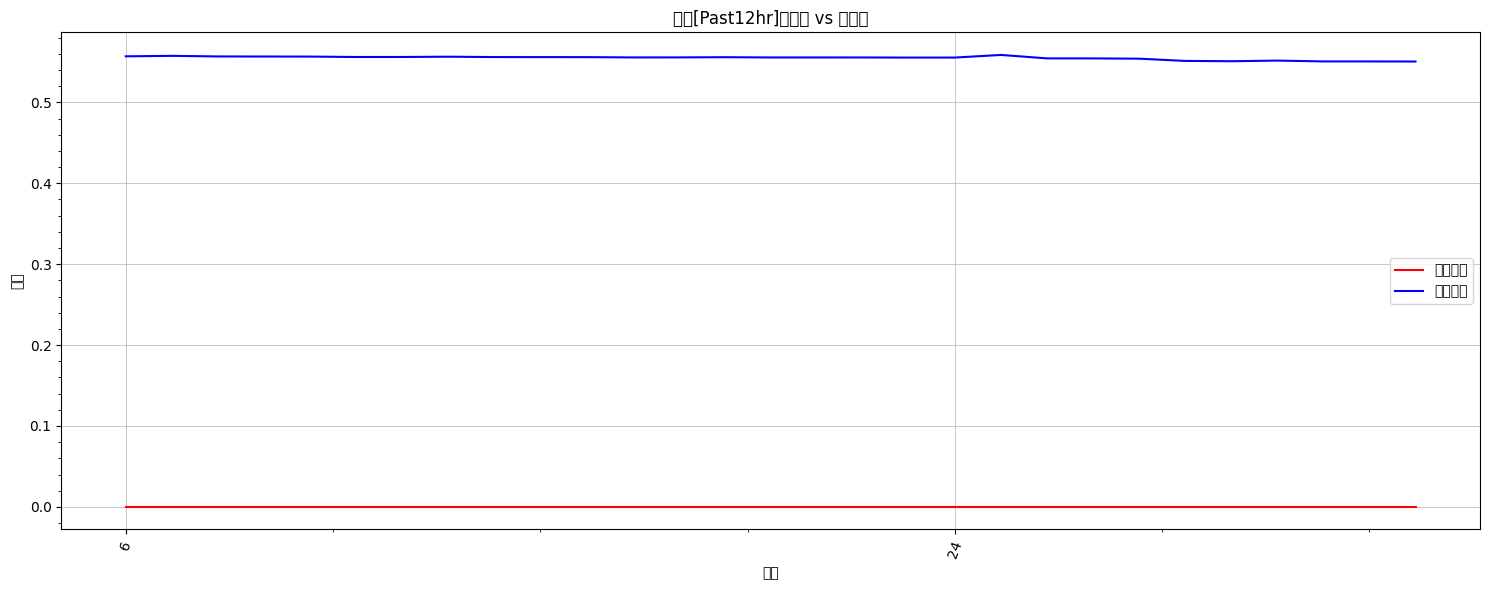

In [33]:
import pandas as pd
df = pd.read_csv('test_file.csv')

features_reserve = ['Past12hr','WindSpeed','AirTemperature','RelativeHumidity','AirPressure']
features_to_train = ['WindSpeed','AirTemperature','RelativeHumidity','AirPressure']  #要用甚麼欄位訓練
#print(df)
predict_lstm(df, '三民', features_reserve, features_to_train, look_back=6, target_column='Past12hr')